# Image Classification on Brain MRIs

So, from the dataset itself, we understand that it is a classification task.

In order to tackle this task, I've decided to use the Vision Transformer (ViT) model because it's a good model for image classification tasks. The ViT model has been proven to work well with a variety of image classification tasks and has a strong track record of performance in the computer vision field.

I will also be fine-tuning the pre-trained Google/ViT-base-patch16-224-in21k model. This particular model has a patch size of 16x16 pixels, which is a good balance between capturing fine details and maintaining spatial information. The 224 refers to the input image size, which is the standard size for many pre-trained models. Finally, the "in21k" in the model's name indicates that it has been pre-trained on a dataset with 21,000 classes. This will help the model to generalize well to the classification task at hand.

So, with the combination of the Vision Transformer model and the fine-tuned pre-trained Google/ViT-base-patch16-224-in21k model, I believe we can achieve strong results on this classification task with the MRI images of the brain.

The Vision Transformer (ViT), which was introduced in [June 2021](https://arxiv.org/abs/2010.11929) by a team of researchers at Google Brain.

![vit_figure.png](https://raw.githubusercontent.com/google-research/vision_transformer/main/vit_figure.png)

In [ ]:
# blocks output in Colab
%%capture

! pip install datasets transformers
! pip install transformers[torch]
! pip install optuna
! pip install huggingface_hub

## Load dataset to fine tune on
Loading and unzipping datset from Google Drive using file id from "https://drive.google.com/file/d/1Fk0davXze4Lc3oQohwYe-4ruJ3wk8a-V/view"

In [ ]:
!gdown --id 1Fk0davXze4Lc3oQohwYe-4ruJ3wk8a-V
!unzip dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/unlabelled/e1e663fb-a3bd-4668-9d5c-910e11a328c6.jpeg  
  inflating: __MACOSX/dataset/unlabelled/._e1e663fb-a3bd-4668-9d5c-910e11a328c6.jpeg  
  inflating: dataset/unlabelled/390aee4c-e555-4ecf-979c-f8c034f5a0bb.jpeg  
  inflating: __MACOSX/dataset/unlabelled/._390aee4c-e555-4ecf-979c-f8c034f5a0bb.jpeg  
  inflating: dataset/unlabelled/10ae0f3a-f741-4ab2-9652-baf3d9077ec2.jpeg  
  inflating: __MACOSX/dataset/unlabelled/._10ae0f3a-f741-4ab2-9652-baf3d9077ec2.jpeg  
  inflating: dataset/unlabelled/38ace7aa-9e52-4b24-9e75-05cee7991c98.jpeg  
  inflating: __MACOSX/dataset/unlabelled/._38ace7aa-9e52-4b24-9e75-05cee7991c98.jpeg  
  inflating: dataset/unlabelled/504e3076-ae7a-4bfe-86c0-ef8e5dc42572.jpeg  
  inflating: __MACOSX/dataset/unlabelled/._504e3076-ae7a-4bfe-86c0-ef8e5dc42572.jpeg  
  inflating: dataset/unlabelled/d101440d-23b2-4783-8883-6d760931ee63.jpeg  
  inflating: __MACOSX/dataset/unlabelled/._d101440d-23b2-4


PLEAE RESTART THE SESSION AFTER INSTALLING THE LIBRARIES.

#File Handeling
File handeling to ensure dataset's load_dataset can easily read in the dataset. We use OS and Shutil's do merge all the MRI images from a given label together.

In [ ]:
import os
import shutil

directory = '/content/dataset'


def move_all_files_to_destination_dir(original_dir, destination_dir):
    # moves all NESTED files in original_dir to destination_dir
    files = []
    for root, dirs, files in os.walk(original_dir):
        for name in files:
            os.rename(root + os.sep + name, destination_dir + os.sep + name)

subdirs = [f.path for f in os.scandir(directory) if f.is_dir()]   # [Folder1, Folder2]
for d in subdirs:
    move_all_files_to_destination_dir(d, d)
    # remove the subdirectories of d after we have moved all files under it
    for sub in os.scandir(d):
        if sub.is_dir():
            shutil.rmtree(sub)

shutil.move("/content/dataset/unlabelled", "/content/")
os.rename("/content/dataset","/content/train")

#Loading the Dataset

We use the datasets library to load the data in using the load_datase. The metadata is automatically loaded when you call load_dataset() and specify imagefolder.

In [ ]:
from datasets import load_dataset, concatenate_datasets, DatasetDict
import optuna
from transformers import set_seed

set_seed(42)

In [ ]:
ds=load_dataset("imagefolder",data_dir="/content/",split='train',drop_labels=False)

Resolving data files:   0%|          | 0/576 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

#Train, Val & Test Split

In [ ]:
ds=ds.train_test_split(test_size=0.2)
ds_t=ds['test'].train_test_split(test_size=0.5)
ds=DatasetDict({
    'train': ds['train'],
    'val': ds_t['train'],
    'test': ds_t['test']})
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 459
    })
    val: Dataset({
        features: ['image', 'label'],
        num_rows: 57
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 58
    })
})

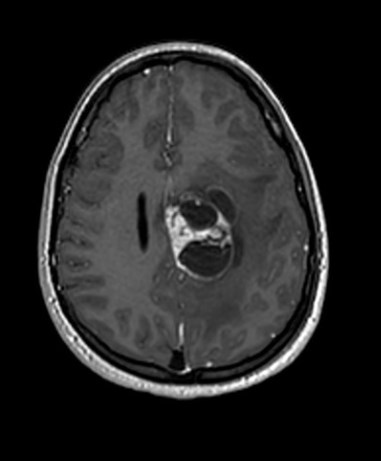

In [ ]:
image = ds['train'][300]['image']
image

In [ ]:
labels = ds['train'].features['label']
labels

ClassLabel(names=['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Meningioma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma', '_NORMAL'], id=None)

#Visualisation
We then take a look at 3 examples from each class of diagnosis of the MRI image.

Filter:   0%|          | 0/459 [00:00<?, ? examples/s]

Filter:   0%|          | 0/459 [00:00<?, ? examples/s]

Filter:   0%|          | 0/459 [00:00<?, ? examples/s]

Filter:   0%|          | 0/459 [00:00<?, ? examples/s]

Filter:   0%|          | 0/459 [00:00<?, ? examples/s]

Filter:   0%|          | 0/459 [00:00<?, ? examples/s]

Filter:   0%|          | 0/459 [00:00<?, ? examples/s]

Filter:   0%|          | 0/459 [00:00<?, ? examples/s]

Filter:   0%|          | 0/459 [00:00<?, ? examples/s]

Filter:   0%|          | 0/459 [00:00<?, ? examples/s]

Filter:   0%|          | 0/459 [00:00<?, ? examples/s]

Filter:   0%|          | 0/459 [00:00<?, ? examples/s]

Filter:   0%|          | 0/459 [00:00<?, ? examples/s]

Filter:   0%|          | 0/459 [00:00<?, ? examples/s]

Filter:   0%|          | 0/459 [00:00<?, ? examples/s]

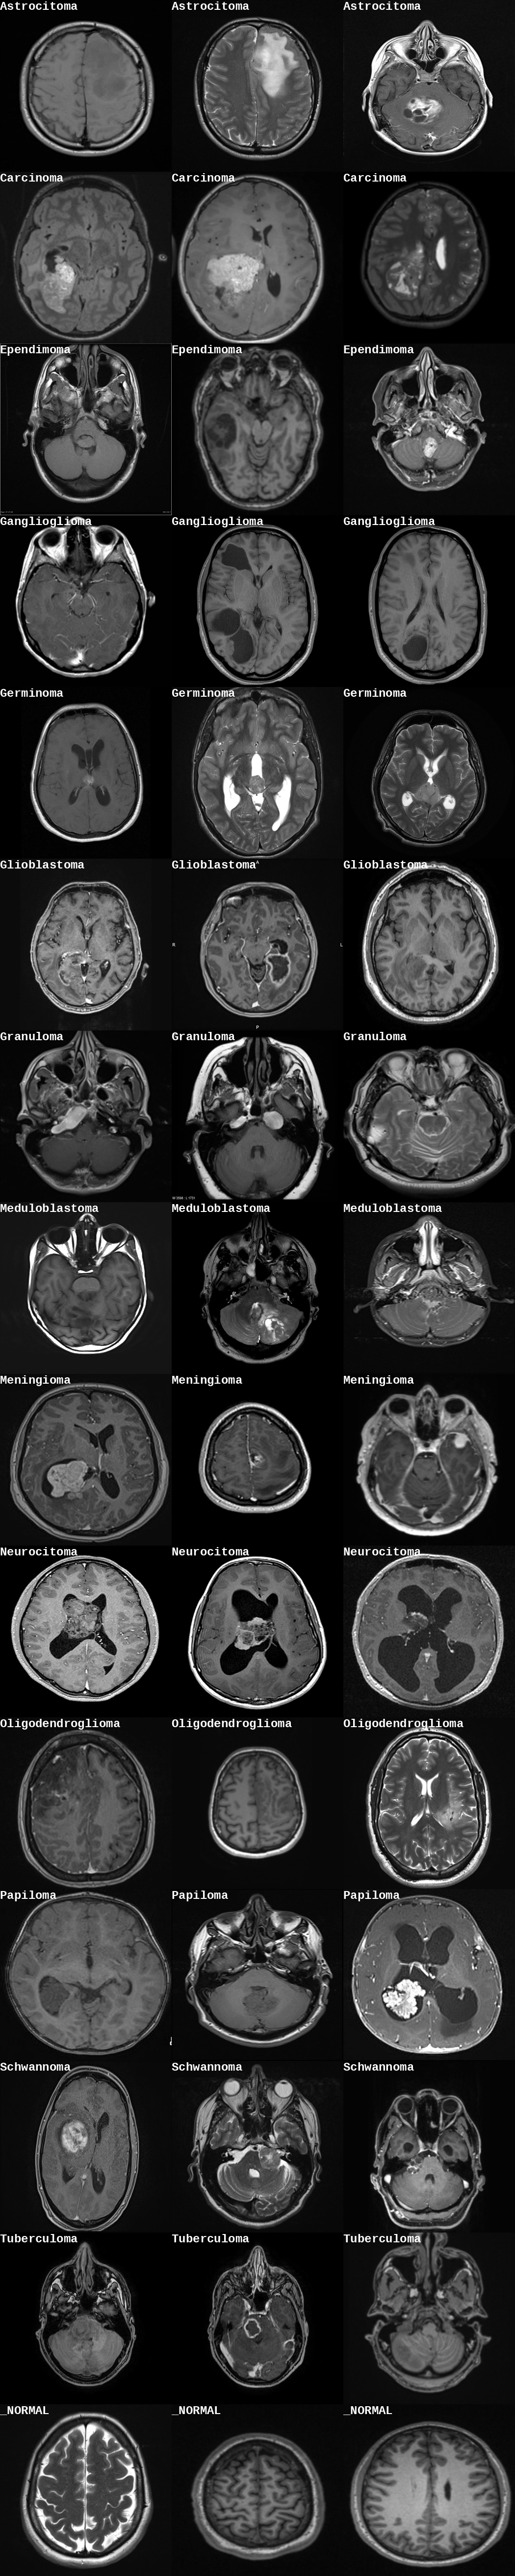

In [ ]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 1, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['label'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['label'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

## Loading ViT Feature Extractor

In our case, we'll be using the [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) model, so lets load it from the 🤗 Hub.

In [ ]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


#Data Preprocessing

In [ ]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

image_mean, image_std = feature_extractor.image_mean, feature_extractor.image_std
size = feature_extractor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [ ]:
#Setting Transforms
ds['train'].set_transform(train_transforms)
ds['val'].set_transform(val_transforms)
ds['test'].set_transform(val_transforms)

# Training and Evaluation

The data is processed and we are ready to start setting up the training pipeline. We will make use of 🤗's Trainer, but that'll require us to do a few things first:

- Define a collate function.

- Define an evaluation metric. During training, the model should be evaluated on its prediction accuracy. We should define a compute_metrics function accordingly.

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the evaluation data and verify that it has indeed learned to correctly classify our images.

### Data Collator

Batches are coming in as lists of dicts, so we just unpack + stack those into batch tensors.

In [ ]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

### Define an evaluation metric

Here, we load the [accuracy](https://huggingface.co/metrics/accuracy) metric from `datasets`, and then write a function that takes in a model prediction + computes the accuracy.

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-10-3044fb6e3895>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
from transformers import ViTForImageClassification

labels = ds['train'].features['label'].names

#OPTUNA

We use OPTUNA for hyper-parameter tuning so we now set up an objective function along with the space within which we want to carry out the search

In [ ]:
LR_MIN = 4e-5
LR_CEIL = 0.01
WD_MIN = 4e-5
WD_CEIL = 0.01
MIN_EPOCHS = 10
MAX_EPOCHS = 20
PER_DEVICE_EVAL_BATCH = 8
PER_DEVICE_TRAIN_BATCH = 8
NUM_TRIALS = 20
SAVE_DIR = 'opt-test'
NAME_OF_MODEL = 'huggingoptunaface'
MAX_LENGTH = 512

In [ ]:
from transformers import TrainingArguments, Trainer

def objective(trial: optuna.Trial):
  model = ViTForImageClassification.from_pretrained(
      model_name_or_path,
      num_labels=len(labels),
      id2label={str(i): c for i, c in enumerate(labels)},
      label2id={c: str(i) for i, c in enumerate(labels)}
  )
  training_args = TrainingArguments(
    output_dir='vit-optuna',
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=trial.suggest_int('num_train_epochs', low = MIN_EPOCHS,high = MAX_EPOCHS),
    fp16=True,
    eval_steps=100,
    logging_steps=10,
    save_strategy="no",
    learning_rate=trial.suggest_float('learning_rate',low=LR_MIN,high=LR_CEIL, log=True),
    weight_decay=trial.suggest_float('weight_decay', WD_MIN, WD_CEIL, log=True),
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
  )

  trainer = Trainer(
      model=model,
      args=training_args,
      data_collator=collate_fn,
      compute_metrics=compute_metrics,
      train_dataset=ds["train"],
      eval_dataset=ds["val"],
      tokenizer=feature_extractor,
  )

  train_results = trainer.train()
  return train_results.training_loss

In [ ]:
def print_custom(text):
    print('\n')
    print(text)
    print('-'*100)

In [ ]:
from optuna.samplers import TPESampler

print_custom('Triggering Optuna study')
sampler = TPESampler(seed=42)                 # Make the sampler behave in a deterministic way.
study = optuna.create_study(study_name='vit-min', direction='minimize',sampler=sampler)
study.optimize(func=objective, n_trials=NUM_TRIALS)

[I 2024-03-04 17:25:57,277] A new study created in memory with name: vit-min




Triggering Optuna study
----------------------------------------------------------------------------------------------------


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2024-03-04 17:27:49,611] Trial 0 finished with value: 2.649413346069787 and parameters: {'num_train_epochs': 14, 'learning_rate': 0.007617559646393048, 'weight_decay': 0.002276866412041495}. Best is trial 0 with value: 2.649413346069787.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2024-03-04 17:29:57,052] Trial 1 finished with value: 1.2198234547314972 and parameters: {'num_train_epochs': 16, 'learning_rate': 9.466366864747961e-05, 'weight_decay': 9.465106234768177e-05}. Best is trial 1 with value: 1.2198234547314972.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2024-03-04 17:31:15,865] Trial 2 finished with value: 2.652067256795949 and parameters: {'num_train_epochs': 10, 'learning_rate': 0.00477637510229448, 'weight_decay': 0.0011053446862783643}. Best is trial 1 with value: 1.2198234547314972.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2024-03-04 17:33:31,094] Trial 3 finished with value: 1.6363802652571797 and parameters: {'num_train_epochs': 17, 'learning_rate': 4.4814687643802985e-05, 'weight_decay': 0.008469263218529859}. Best is trial 1 with value: 1.2198234547314972.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2024-03-04 17:36:02,110] Trial 4 finished with value: 0.9765888725131913 and parameters: {'num_train_epochs': 19, 'learning_rate': 0.0001291922435440605, 'weight_decay': 0.00010916045941167609}. Best is trial 4 with value: 0.9765888725131913.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2024-03-04 17:37:38,040] Trial 5 finished with value: 1.215571369247875 and parameters: {'num_train_epochs': 12, 'learning_rate': 0.0002145925487841219, 'weight_decay': 0.0007250942038570209}. Best is trial 4 with value: 0.9765888725131913.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2024-03-04 17:39:29,786] Trial 6 finished with value: 1.1595963539161118 and parameters: {'num_train_epochs': 14, 'learning_rate': 0.00019971468436868472, 'weight_decay': 0.001172860950442325}. Best is trial 4 with value: 0.9765888725131913.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2024-03-04 17:40:57,970] Trial 7 finished with value: 1.3291357796767662 and parameters: {'num_train_epochs': 11, 'learning_rate': 0.00020072678671998915, 'weight_decay': 0.0003023943782398931}. Best is trial 4 with value: 0.9765888725131913.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2024-03-04 17:42:56,260] Trial 8 finished with value: 2.626312615405554 and parameters: {'num_train_epochs': 15, 'learning_rate': 0.0030539705376293504, 'weight_decay': 0.00012046634732598355}. Best is trial 4 with value: 0.9765888725131913.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2024-03-04 17:44:54,795] Trial 9 finished with value: 2.6105647251523774 and parameters: {'num_train_epochs': 15, 'learning_rate': 0.001053500115899411, 'weight_decay': 5.169461371196797e-05}. Best is trial 4 with value: 0.9765888725131913.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2024-03-04 17:47:32,536] Trial 10 finished with value: 2.607555185515305 and parameters: {'num_train_epochs': 20, 'learning_rate': 0.0008752878885720143, 'weight_decay': 0.00022224122297932384}. Best is trial 4 with value: 0.9765888725131913.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2024-03-04 17:50:03,475] Trial 11 finished with value: 1.0567647454526594 and parameters: {'num_train_epochs': 19, 'learning_rate': 0.00027029114664229225, 'weight_decay': 0.0022920581715839866}. Best is trial 4 with value: 0.9765888725131913.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2024-03-04 17:52:42,733] Trial 12 finished with value: 0.8811811428645562 and parameters: {'num_train_epochs': 20, 'learning_rate': 0.00034925166307083757, 'weight_decay': 0.004322734259915892}. Best is trial 12 with value: 0.8811811428645562.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2024-03-04 17:55:05,567] Trial 13 finished with value: 2.4536003984253982 and parameters: {'num_train_epochs': 18, 'learning_rate': 0.0005196597849501501, 'weight_decay': 0.007414040591556133}. Best is trial 12 with value: 0.8811811428645562.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2024-03-04 17:57:44,343] Trial 14 finished with value: 1.2234711359287131 and parameters: {'num_train_epochs': 20, 'learning_rate': 6.94831287987468e-05, 'weight_decay': 0.003531095178933724}. Best is trial 12 with value: 0.8811811428645562.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2024-03-04 18:00:06,311] Trial 15 finished with value: 2.6331113435299462 and parameters: {'num_train_epochs': 18, 'learning_rate': 0.001804578750394006, 'weight_decay': 0.0002313835176393504}. Best is trial 12 with value: 0.8811811428645562.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2024-03-04 18:02:44,134] Trial 16 finished with value: 2.5857587584133808 and parameters: {'num_train_epochs': 20, 'learning_rate': 0.0004898866956530509, 'weight_decay': 0.00041846975525388334}. Best is trial 12 with value: 0.8811811428645562.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2024-03-04 18:05:07,241] Trial 17 finished with value: 1.0438073569787416 and parameters: {'num_train_epochs': 18, 'learning_rate': 0.00011709669228698972, 'weight_decay': 5.237912775159603e-05}. Best is trial 12 with value: 0.8811811428645562.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2024-03-04 18:07:21,631] Trial 18 finished with value: 1.765301791456118 and parameters: {'num_train_epochs': 17, 'learning_rate': 0.00039091582630048066, 'weight_decay': 0.00011712495983216177}. Best is trial 12 with value: 0.8811811428645562.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2024-03-04 18:09:52,194] Trial 19 finished with value: 0.939250669981304 and parameters: {'num_train_epochs': 19, 'learning_rate': 0.00012441364016392716, 'weight_decay': 0.005041087088204805}. Best is trial 12 with value: 0.8811811428645562.


#Plotting Tuning Results

In [ ]:
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances

In [ ]:
plot_optimization_history(study)

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
plot_param_importances(study)

Saving and Using Best Parameters

In [ ]:
print_custom('Finding study best parameters')
best_lr = float(study.best_params['learning_rate'])
best_weight_decay = float(study.best_params['weight_decay'])
best_epoch=float(study.best_params['num_train_epochs'])



Finding study best parameters
----------------------------------------------------------------------------------------------------


In [ ]:
print_custom('Extract best study params')
print(f'The best learning rate is: {best_lr}')
print(f'The best weight decay is: {best_weight_decay}')
print(f'The best epoch is : {best_epoch}')


print_custom('Create dictionary of the best hyperparameters')
best_hp_dict = {
    'best_learning_rate' : best_lr,
    'best_weight_decay': best_weight_decay,
    'best_epoch': best_epoch
}



Extract best study params
----------------------------------------------------------------------------------------------------
The best learning rate is: 0.00034925166307083757
The best weight decay is: 0.004322734259915892
The best epoch is : 20.0


Create dictionary of the best hyperparameters
----------------------------------------------------------------------------------------------------


#Final Model Training
We then use the best hyperparameters to train our final model to finally test it.

In [ ]:
model_opt = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)
training_args_opt = TrainingArguments(
  output_dir="./vit-final",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=best_epoch,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=best_lr,
  weight_decay=best_weight_decay,
  save_total_limit=4,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

trainer_opt = Trainer(
    model=model_opt,
    args=training_args_opt,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=ds["train"],
    eval_dataset=ds["val"],
    tokenizer=feature_extractor,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer_opt_m=trainer_opt.train()

In [ ]:
trainer_opt.save_model()
trainer_opt.log_metrics("train", trainer_opt_m.metrics)
trainer_opt.save_metrics("train", trainer_opt_m.metrics)
trainer_opt.save_state()

***** train metrics *****
  epoch                    =        30.0
  total_flos               = 993897231GF
  train_loss               =       1.068
  train_runtime            =  0:05:00.12
  train_samples_per_second =       45.88
  train_steps_per_second   =       2.899


In [ ]:
metrics = trainer_opt.evaluate(ds['val'])
trainer_opt.log_metrics("eval", metrics)
trainer_opt.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       30.0
  eval_accuracy           =     0.5965
  eval_loss               =     1.3376
  eval_runtime            = 0:00:00.54
  eval_samples_per_second =    105.363
  eval_steps_per_second   =     14.788


#Evaluating Model on Test Set

In [ ]:
metrics = trainer_opt.evaluate(eval_dataset=ds['test'])

In [ ]:
metrics

{'eval_loss': 1.2528704404830933,
 'eval_accuracy': 0.6724137931034483,
 'eval_runtime': 0.7306,
 'eval_samples_per_second': 79.388,
 'eval_steps_per_second': 10.95,
 'epoch': 30.0}

In [ ]:
outputs = trainer_opt.predict(ds['test'])
outputs.metrics

{'test_loss': 1.2528704404830933,
 'test_accuracy': 0.6724137931034483,
 'test_runtime': 0.5815,
 'test_samples_per_second': 99.746,
 'test_steps_per_second': 13.758}

#Classification Results

We look at the confusion matrix to see how well the model has performed on the test set.

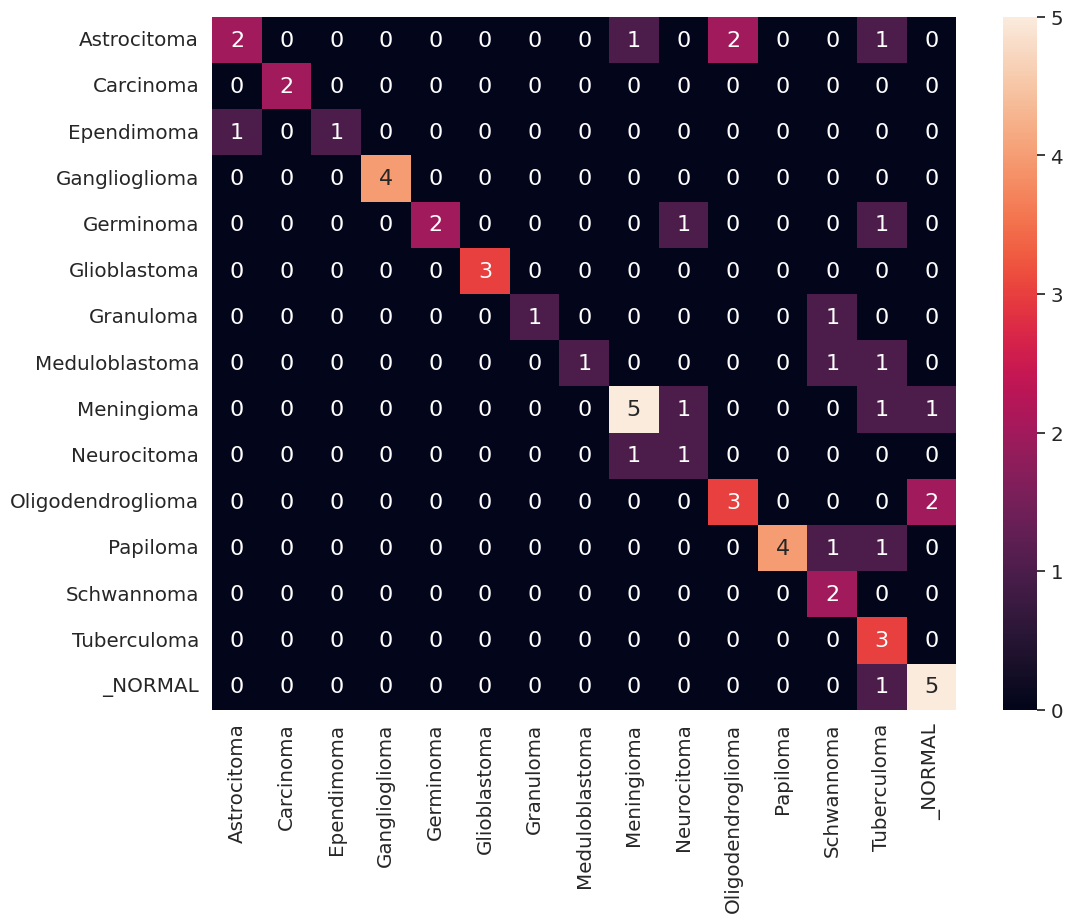

In [ ]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

id2label={str(i): c for i, c in enumerate(labels)}
cm = confusion_matrix(y_true, y_pred,labels=range(len(id2label.keys())))
df_cm = pd.DataFrame(cm, id2label.values(), id2label.values())
plt.figure(figsize=(12,9))
sn.set(font_scale=1.3) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
# plt.xticks(rotation=45)

plt.show()

#Saving the model

In [ ]:
model_opt.save_pretrained("/content/FineTuned-Contineu")

#Pushing to Hub (Optional)

In [ ]:
# from huggingface_hub import notebook_login
# notebook_login()
# model_opt.push_to_hub('Vengeance12/Contineu')

Zipping and downloading model

In [ ]:
!zip -r /content/FineTuned-Contineu.zip /content/FineTuned-Contineu

from google.colab import files
files.download("/content/FineTuned-Contineu.zip")